### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models", "saved_models", "raw_hybrid_two_class_best.pth")

### Load Raw dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

# Remap labels
df["label"] = df["label"].map({
    0: 0,  # SR → non-AF
    1: 0,  # Pre-AF → non-AF
    2: 1   # AF → AF
})

# Pick raw RRI columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"

# Extract feature matrix and labels
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or Inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded raw samples:", X.shape)
print("Class counts:", np.bincount(y))
print("Unique labels:", np.unique(y))


Loaded raw samples: (14357, 50)
Class counts: [9557 4800]
Unique labels: [0 1]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SMOTE on training only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.bincount(y_train_res))

Splits -> train: (9188, 50) val: (2297, 50) test: (2872, 50)
After SMOTE train distribution: [6116 6116]


### Compute class weights

In [4]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [1. 1.]


### Compute focal loss

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

### Define model class

In [6]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [7]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (hyperparameter tuning)

In [8]:
import itertools
from sklearn.metrics import f1_score

def train_with_hyperparameter_tuning(model_class, input_dim, num_classes,
                                     train_dataset, val_dataset,
                                     class_weights_tensor,
                                     param_grid,
                                     save_path=OUT_MODEL,
                                     epochs=8,
                                     patience=2,
                                     device=None):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    class_weights_tensor = class_weights_tensor.to(device)

    best_f1 = 0.0
    best_params = None
    best_state = None

    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print("\nTrying params:", params)

        # recreate loaders with chosen batch size
        batch_size = params["batch_size"]
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = model_class(dim=input_dim, num_classes=num_classes).to(device)
        if params["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
        elif params["optimizer"] == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
        else:
            raise ValueError("Unsupported optimizer")

        criterion = FocalLoss(alpha=class_weights_tensor, gamma=params.get("gamma", 2.0))
        epochs_no_improve = 0
        local_best = 0.0

        for epoch in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
            train_loss = running_loss / len(train_loader.dataset)

            # validation
            model.eval()
            preds, trues = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    _, p = torch.max(out, dim=1)
                    preds.extend(p.cpu().numpy()); trues.extend(yb.cpu().numpy())

            val_f1 = f1_score(trues, preds, average="weighted")
            print(f"  epoch {epoch} train_loss: {train_loss:.4f} val_f1: {val_f1:.4f}")

            if val_f1 > local_best:
                local_best = val_f1
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("  early stopping")
                    break

        # end epochs for this combo
        if local_best > best_f1:
            best_f1 = local_best
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  -> New global best. Saved model.")

    print(f"\nGlobal best val F1: {best_f1:.4f} params: {best_params}")
    return best_params, best_f1, best_state

# Build datasets (reuse existing X_train_res, y_train_res, X_val, y_val)
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

# Recommended small grid to start — tune and then expand if needed
param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_hyperparameter_tuning(
    model_class=HybridNODEAttentionModel,
    input_dim=input_dim,
    num_classes=num_classes,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    class_weights_tensor=class_weights_tensor,
    param_grid=param_grid,
    save_path=OUT_MODEL,
    epochs=8,
    patience=2,
    device=device
)

print("Best params:", best_params, "Best val F1:", best_f1)


Total combinations: 8

Trying params: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  epoch 1 train_loss: 0.0918 val_f1: 0.8688
  epoch 2 train_loss: 0.0868 val_f1: 0.8598
  epoch 3 train_loss: 0.0838 val_f1: 0.8577
  early stopping
  -> New global best. Saved model.

Trying params: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  epoch 1 train_loss: 0.0999 val_f1: 0.8553
  epoch 2 train_loss: 0.0936 val_f1: 0.8509
  epoch 3 train_loss: 0.0922 val_f1: 0.8524
  early stopping

Trying params: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  epoch 1 train_loss: 0.0928 val_f1: 0.8639
  epoch 2 train_loss: 0.0865 val_f1: 0.8729
  epoch 3 train_loss: 0.0828 val_f1: 0.8590
  epoch 4 train_loss: 0.0796 val_f1: 0.8822
  epoch 5 train_loss: 0.0763 val_f1: 0.8631
  epoch 6 train_loss: 0.0735 val_f1: 0.8826
  epoch 7 train_loss: 0.0715 val_f1: 0.8832
  epoch 8 train_loss: 0.0688 val_f1: 0.8825
  -> New global best. Saved model.

Trying params: {'lr': 0.001, 'batch_size': 32, 'opt

### Final evaluation on test set

In [9]:
# --- Recreate model and load best weights ---
model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model state from training.")
else:
    model.load_state_dict(torch.load(OUT_MODEL, map_location=device))
    print("Loaded model state from file.")

# --- Prepare test data ---
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Evaluate ---
model.eval()
test_preds, test_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        _, p = torch.max(out, dim=1)
        test_preds.extend(p.cpu().numpy())
        test_trues.extend(yb.numpy())

# --- Print metrics ---
print("Test class counts:", np.bincount(test_trues))
print("Accuracy:", accuracy_score(test_trues, test_preds))
print("F1 (weighted):", f1_score(test_trues, test_preds, average="weighted"))
print("\nClassification report:\n", classification_report(test_trues, test_preds, target_names=["SR", "AF"]))
print("\nConfusion matrix:\n", confusion_matrix(test_trues, test_preds))


Loaded best model state from training.
Test class counts: [1912  960]
Accuracy: 0.879874651810585
F1 (weighted): 0.8811523896253237

Classification report:
               precision    recall  f1-score   support

          SR       0.93      0.89      0.91      1912
          AF       0.79      0.87      0.83       960

    accuracy                           0.88      2872
   macro avg       0.86      0.88      0.87      2872
weighted avg       0.88      0.88      0.88      2872


Confusion matrix:
 [[1693  219]
 [ 126  834]]


In [10]:
prob_danger = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)[:, 1]   # class 1 = AF (danger)
        prob_danger.extend(probs.cpu().numpy())

prob_danger = np.array(prob_danger)
test_trues = np.array(test_trues)  

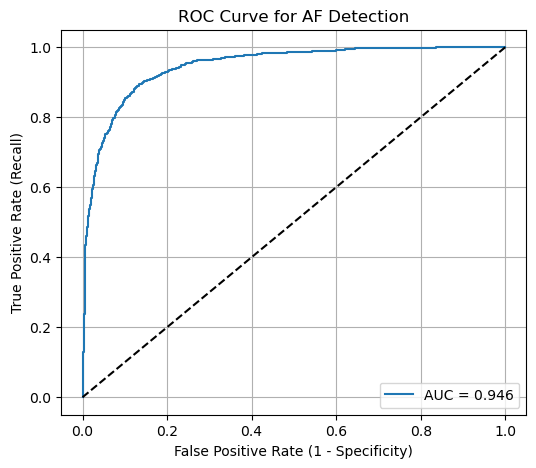

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thr = roc_curve(test_trues, prob_danger)
auc = roc_auc_score(test_trues, prob_danger)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve for AF Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


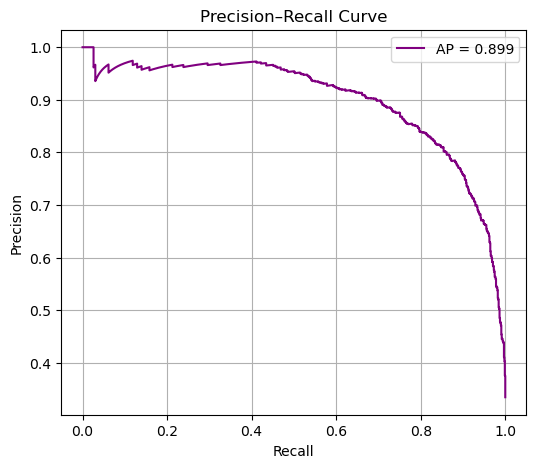

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(test_trues, prob_danger)
ap = average_precision_score(test_trues, prob_danger)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='purple', label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
